In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

pontoReal = np.array([[2.5e-2, -2.5e-2, 0],
                    [2.5e-2, 2.5e-2, 0],
                    [-2.5e-2, 2.5e-2, 0],
                    [-2.5e-2, -2.5e-2, 0]], dtype=np.float32)

K = np.array([[215.6810060961547, 0.0, 376.5], [0.0, 215.6810060961547, 240.5], [0.0, 0.0, 1.0]],dtype=np.float32)

In [2]:

def inverteTransformacao(R, t):
    RInverso = np.transpose(R)

    tInverso  = - np.matmul(RInverso, t)

    return RInverso, tInverso

#Procura quadrados na imagem usando uma mascara
def procuraQuadrado(mascara):
    kernel = np.ones((5,5),np.uint8)
    
    bordas = cv.Canny(mascara, 100, 500, kernel)
    contours,hierarchy = cv.findContours(bordas, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    quadrados = []

    for i in range(len(contours)):
        epsilon = 0.1*cv.arcLength(contours[i],True)
        approx = cv.approxPolyDP(contours[i],epsilon,True)

        if(len(approx) < 4):
            continue

        if not cv.isContourConvex(approx):
            continue

        if cv.contourArea(approx) < 100:
            continue

        quadrado = []

        for point in approx:
            quadrado.append([point[0][0], point[0][1]])
        
        quadrados.append(quadrado)

    quadrados = np.array(quadrados)

    i = 0

    while(len(quadrados)-2 >= i):
        if np.linalg.norm(quadrados[i+1][0]-quadrados[i][0]) < 5:
            quadrados = np.delete(quadrados, i, 0)
            
        i+=1
    
    return quadrados

#Estima a pose do sensor a partir de seus cantos na imagem
def estimaPoseSensor(quad):


    a, RCamObj, tCamObj, _ = cv.solvePnPRansac(pontoReal,quad , K, np.zeros((5,1)))

    tCamObj = tCamObj.ravel()

    RCamObj, _ = cv.Rodrigues(RCamObj)

    RObjCamera, tObjCamera = inverteTransformacao(RCamObj, tCamObj)

    #return RObjCamera, tObjCamera 

    return RCamObj, tCamObj

tSensorCamera = []
RSensorCamera = []

#Recebe a imagem, procura os quadrados e publica
def processaImagem(img):

    #Calcula as mascaras
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    min_verde = np.array([50,200,0],np.uint8)
    max_verde = np.array([150,255,255],np.uint8)
    masc_verde = cv.inRange(hsv,min_verde,max_verde)

    min_verm = np.array([0,210,100],np.uint8)
    max_verm = np.array([8,255,255],np.uint8)
    masc_verm = cv.inRange(hsv,min_verm,max_verm)


    #Procura os quadrados nas imagens
    quadVerde = procuraQuadrado(masc_verde)
    quadVerm = procuraQuadrado(masc_verm)


    tSensor = []
    RSensor = []

    #Calcula as poses e publica
    quadVerde = quadVerde.astype(np.float32)

    for quad in quadVerde:
        R, t = estimaPoseSensor(quad)

        tSensor.append(t)
        RSensor.append(R)

    quadVerm = quadVerm.astype(np.float32)

    print(len(quadVerm))

    for quad in quadVerm:
        R, t = estimaPoseSensor(quad)

        #tSensor.append(t)
        #RSensor.append(R)

    tSensorCamera.append(tSensor)
    RSensorCamera.append(RSensor)

    if len(quadVerm) == 0:
        return quadVerde
    elif len(quadVerde) == 0:
        return quadVerm
    else:
        return np.append(quadVerm, quadVerde, 0)

In [39]:
def imprimeQuadrado(quadrado, img):
    imgDraw = img.copy()
    
    for point in quadrado:
        cv.circle(imgDraw, (point[0], point[1]), 10, (255,0,255), -1)

    plt.imshow(cv.cvtColor(imgDraw,cv.COLOR_BGR2RGB))
    plt.show()

def imprimeTodosQuadrados(quadrados, img):
    imgDraw = img.copy()
    for quad in quadrados:
        for point in quad:
            cv.circle(imgDraw, (point[0], point[1]), 5, (255,0,255), -1)
    
    plt.imshow(cv.cvtColor(imgDraw,cv.COLOR_BGR2RGB))
    plt.show()

def salvaTodosQuadrados(quadrados, img, i):
    imgDraw = img.copy()
    
    for quad in quadrados:
        for point in quad:
            cv.circle(imgDraw, (point[0], point[1]), 5, (255,0,255), -1)

    cv.imwrite("result/"+str(i)+".png", imgDraw)

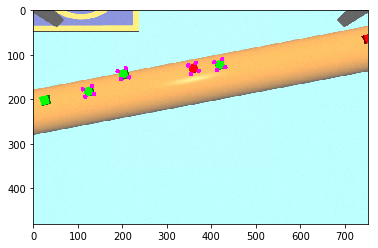

In [25]:
img = cv.imread("Sensor/img1.png")

quad = processaImagem(img)

imprimeTodosQuadrados(quad, img)

In [3]:
for i in range(0, 95):
    name = "/home/elton/Documentos/GitHub/drone_data/Sensor/img/frame" + ((4-len(str(i)))*"0"+str(i)) + ".jpg"

    img = cv.imread(name)

    quad = processaImagem(img)

    #salvaTodosQuadrados(quad, img, i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
1
1
1
0
0
0
0
0
1
1
0
1
1
2
1
1
0
1
1
1
1
0
0
1
1
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [6]:
from scipy.spatial.transform import Rotation
import csv

tDroneWorld = []
RDroneWorld = []


with open("/home/elton/Documentos/GitHub/drone_data/Sensor/poses.csv", 'r') as arq:
    reader = csv.reader(arq, delimiter=',')

    arq.seek(0)

    for row in reader:
        t = []
        RQuat = []

        for i in range(3):
            t.append(float(row[i]))
        for i in range(4):
            RQuat.append(float(row[i+3]))

        R = Rotation.from_quat(RQuat).as_dcm()

        tDroneWorld.append(t)
        RDroneWorld.append(R)

In [7]:
#RSensorWorld = np.matmul(RDroneWordl, RSensorCamera)
#tSensorWordl = position+np.matmul(RDroneWordl, tSensorCamera)

RSensorWorldAll = []
tSensorWorldAll = []

tCameraDrone = [0.050, 0.0, -0.093]
RCameraDrone = [0, 0.707, 0.0, 0.707]
RCameraDrone = Rotation.from_quat(RCameraDrone).as_dcm()

#RCameraDrone , tCameraDrone = inverteTransformacao(RCameraDrone, tCameraDrone)


for i in range(95):
    for j in range(len(tSensorCamera[i])):
        
        RSensorDrone = np.matmul(RCameraDrone, RSensorCamera[i][j])
        RSensorWorld = np.matmul(RDroneWorld[i], RSensorDrone) 

        tSensorDrone = tCameraDrone + np.matmul(RCameraDrone, tSensorCamera[i][j])
        tSensorWorld = tDroneWorld[i] + np.matmul(RDroneWorld[i], tSensorDrone)

        RSensorWorldAll.append(RSensorWorld)
        tSensorWorldAll.append(tSensorWorld)

        #tDrone = -np.array(tCameraDrone) + np.matmul(np.linalg.inv(RCameraDrone), -tSensorCamera[i][j])
        #tWorld = -np.array(tDroneWorld[i]) + np.matmul(np.linalg.inv(RDroneWorld[i]), tDrone)


        #RSensorWorldAll.append(np.eye(3))
        #tSensorWorldAll.append(tWorld)

tSensorWorldAll = np.array(tSensorWorldAll)
RSensorWorldAll = np.array(RSensorWorldAll)

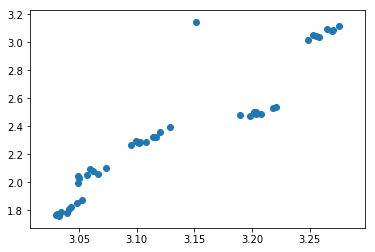

In [8]:
from matplotlib import pyplot as plt

tSensor2D = np.delete(tSensorWorldAll,2, 1)

tSensor2D[:,1] = -tSensor2D[:,1]

x, y = zip(*tSensor2D)

plt.scatter(x, y)
plt.show()

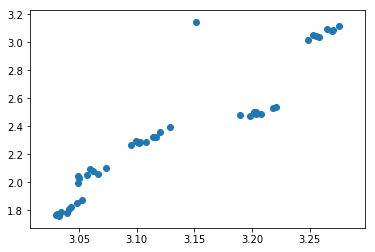

In [276]:
from matplotlib import pyplot as plt

tSensor2D = np.delete(tSensorWorldAll,2, 1)

tSensor2D[:,1] = -tSensor2D[:,1]

x, y = zip(*tSensor2D)

plt.scatter(x, y)

plt.show()

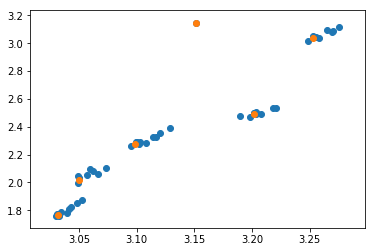

In [279]:
from matplotlib import pyplot as plt

tSensor2D = np.delete(tSensorWorldAll,2, 1)

tSensor2D[:,1] = -tSensor2D[:,1]

x, y = zip(*tSensor2D)

plt.scatter(x, y)


s = []

s.append(tSensor2D[0])

for i in range(len(tSensor2D)):
    existe = False

    for j in range(len(s)):
        #if np.linalg.norm(np.array(s[j])-tSensor2D[i]) < 0.1:
        if abs(s[j][0]-tSensor2D[i][0]) < 0.1 and abs(s[j][1]-tSensor2D[i][1]) < 0.1:
            s[j][0] += tSensor2D[i][0]
            s[j][1] += tSensor2D[i][1]

            s[j][0] /= 2
            s[j][1] /= 2

            existe = True
            break

        
    
    if existe == False:
        s.append(tSensor2D[i])


s = np.array(s)

x, y = zip(*s)

plt.scatter(x, y)
plt.show()


TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [194]:
 def toHomog(R, t):
    A = np.zeros((4,4))
    A[:3,:3]  = R

    for i in range(3):
        A[i][3] = t[i]

    return A

In [195]:
toHomog(RCameraDrone, tCameraDrone)

array([[ 0.   , -1.   ,  0.   ,  0.05 ],
       [-1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.   , -1.   , -0.093],
       [ 0.   ,  0.   ,  0.   ,  0.   ]])

In [255]:
y

(-1.3026890459662051,
 -1.3194901135710955,
 -1.2253782841035861,
 -1.2047437085366646,
 -1.1734613180140949,
 -1.1616447740508777,
 -2.925118157988885,
 -2.9160661054400236,
 -2.9124735084420221,
 -2.8882169510924189,
 -2.9109510784099304,
 -3.9351760514581535,
 -3.9500598018043256,
 -3.9258326656471767,
 -3.8989650407226231,
 -5.1305403648719405,
 -5.1096412690247455,
 -5.1087229107563514,
 -5.0872838385790784,
 -5.0902936798159466,
 -5.0722558307782784,
 -5.0784179288824314,
 -5.0658465444921248)

In [200]:
A[:3,:3]

array([[ 0., -1.,  0.],
       [-1.,  0.,  0.],
       [ 0., -0., -1.]])

In [260]:
tSensor2D[:,1] = -tSensor2D[:,1]

In [261]:
tSensor2D

array([[ 2.90679682,  1.30268905],
       [ 2.91531651,  1.31949011],
       [ 2.89553803,  1.22537828],
       [ 2.8900416 ,  1.20474371],
       [ 2.88012791,  1.17346132],
       [ 2.8821485 ,  1.16164477],
       [ 3.24018178,  2.92511816],
       [ 3.23960593,  2.91606611],
       [ 3.23447716,  2.91247351],
       [ 3.22854705,  2.88821695],
       [ 3.22987855,  2.91095108],
       [ 3.40868801,  3.93517605],
       [ 3.41484771,  3.9500598 ],
       [ 3.39247298,  3.92583267],
       [ 3.39884055,  3.89896504],
       [ 3.61656936,  5.13054036],
       [ 3.61221181,  5.10964127],
       [ 3.6110959 ,  5.10872291],
       [ 3.60447102,  5.08728384],
       [ 3.60447957,  5.09029368],
       [ 3.60138532,  5.07225583],
       [ 3.60127432,  5.07841793],
       [ 3.60319702,  5.06584654]])